# 基于MindSpore Quantum的Shor算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_shor_algorithm.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_shor_algorithm.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/shor_algorithm.ipynb)

## Shor算法简介

Shor算法在量子计算机上分解整数$N$的时间复杂度为$logN$的多项式，几乎是对已知最有效的经典因数分解算法的$e$指数级加速，这种加速有可能在量子计算机上中断如RSA的现代加密机制。

## Shor算法基本思路

Shor算法要解决的主要问题是：给定一个整数$N$，找出它的质因数。即对一个给定的较大数$N$在多项式时间内确定两个素因子 $p1$和$p2$满足$p1\cdot p2=N$。在介绍Shor算法步骤之前，先介绍一些数论知识。

因子分解涉及到数论里的一些知识，可以将因子分解问题归结为函数

$$
f(x)=a^x \bmod N
$$

对于$a$的周期查找（$a$和$N$互质，否则通过调用$gcd(a,N)$就可以马上得到一个因子）。由于函数$f(x)$存在周期$r$满足$f(x)=f(x+r)$。在这种情形下，就可得

$$
a^x=a^{x+r} \bmod N\, \forall x
$$

令$x=0$，得到$a^r=1+qN$，其中$q$为某一整数，即

$$
a^r-1=(a^{r/2}-1)(a^{r/2}+1)=qN
$$

这也表明对于$N$使用$gcd$就可以找到其因子。

因此，Shor算法的核心在于，将大数分解的问题转化为找周期的问题。由于量子计算可以利用叠加态进行并行计算，因此通过量子算法我们可以很快地找到函数$f(x)$的周期$r$（具体的原理和步骤请参考本文档中的`周期查找算法`）。总的来说，我们需要在量子线路中实现$f(|x\rangle)=a^{|x\rangle} \bmod N$的函数运算，可以构造一个酉矩阵$U_{a,N}$使得$U_{a,N}|x\rangle |y\rangle \rightarrow |x\rangle |y \oplus f(x) \rangle$，然后利用量子傅立叶变换我们就可以找到周期$r$满足$a^r\equiv 1( \bmod N)$。

下面以 $N=15$为例，介绍Shor算法在因子分解的步骤：

1. 选择一个任意的数字，比如$a=2(<15)$

2. 求最大公约数，$gcd(a,N)=gcd(2,15)=1$

3. 找函数$f(x)=a^x \bmod N$的周期，使得$f(x+r)=f(x)$

4. 通过量子电路图运算得到$r=4$

5. 求最大公约数，$\gcd(a^{r/2}+1,N)=\gcd(5,15)=5$

6. 求最大公约数，$\gcd(a^{r/2}-1,N)=\gcd(3,15)=3$

7. $N=15$分解得到的质数结果为3和5，分解完成。

Shor算法的量子电路如下图所示：

![shor's algorithm circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/shor_algorithm_circuit.png)

## 通过MindSpore Quantum实现Shor算法

首先，导入需要用到的模块。

In [1]:
#pylint: disable=W0611
import numpy as np
from fractions import Fraction
from mindquantum.core.gates import X, H, UnivMathGate, Measure
from mindquantum.core.circuit import Circuit, UN
from mindquantum.algorithm.library import qft
from mindquantum.simulator import Simulator

从Shor算法的基本思路我们可以看出，Shor算法最核心的部分就在于由量子计算机处理的周期查找算法，而周期查找算法中最困难的地方就是将态$|x\rangle |y\rangle$变为$|x\rangle |y \oplus f(x) \rangle$的算子$U$，这个算子的量子线路构造较为复杂，因此以下我们先通过经典计算机算出算子$U$并当作一个Oracle，以便本文档可以整体而直观地演示出Shor算法。

### 构造Oracle

Shor算法的核心量子部分是周期查找，其关键在于高效实现一个酉算子 $U_{a,N}$。这个算子作用在两个量子寄存器上（寄存器1存储指数 $x$，寄存器2存储辅助计算结果 $y$），并执行可逆的模幂运算。

具体来说，我们需要构建的酉算子 $U_{a,N}$ 必须精确实现以下变换，对于所有可能的输入基态 $|x\rangle|y\rangle$：

$$
U_{a,N} |x\rangle |y\rangle = |x\rangle |y \oplus (a^x \bmod N)\rangle
$$

其中：

* $|x\rangle$ 是大小为 $q$ 比特的寄存器，用于存储 $0$ 到 $Q-1$（$Q=2^q \ge N$）的指数。
* $|y\rangle$ 也是大小为 $q$ 比特的寄存器，用于存储中间结果。
* $a^x \bmod N$ 是经典的模幂计算结果。
* $\oplus$ 表示按位异或（XOR）操作。选择XOR是为了方便构建对应的酉矩阵（置换矩阵），并确保操作的可逆性。

虽然完整的 $|y \oplus f(x)\rangle$ 变换需要更复杂的量子电路（如量子模加器和模乘器），但我们可以直接构建这个 $2^{2q} \times 2^{2q}$ 的酉矩阵 $U_{a,N}$。该矩阵本质上是一个置换矩阵，它将每个输入基态 $|x\rangle|y\rangle$ 唯一地映射到输出基态 $|x\rangle|y \oplus (a^x \bmod N)\rangle$。

#### 实现步骤

1. **确定比特数：**
    * **目标寄存器 (寄存器2):** 需要 $q = \lceil \log_{2} N \rceil$ 个量子比特来存储 $a^x \bmod N$ 的结果 (范围从 $0$ 到 $N-1$)。
    * **控制寄存器 (寄存器1):** 存储指数 $x$。为了保证量子傅立叶变换能够以高概率给出周期 $r$ 的相关信息，该寄存器中的量子比特数 $t_q$ 应满足 $2^{t_q} \ge N^2$，即 $t_q \ge 2 \log_{2} N$。因此，理论上通常选择 $t_q = 2q$。令 $Q_{ctrl} = 2^{t_q}$ 为控制寄存器的状态空间大小。
    * **本教程的简化：** 由于本教程主要用于演示，并且考虑到模拟大规模量子系统所需的资源，我们在实现中使用 $t_q = q$ 个量子比特作为控制寄存器，即 $Q_{ctrl} = 2^q$。此时，总量子比特数为 $n_{total} = q + t_q = 2q$。虽然这种简化在 $N=15, a=2$ 的示例中仍可得到正确结果，但对于更大的 $N$，使用 $t_q = q$ 会显著降低找到正确周期 $r$ 的概率，可能需要多次尝试或只得到 $r$ 的因子，甚至失败。
    * 因此，在本教程的后续部分，当提到控制寄存器的比特数或其对应的状态数 $Q$ 时，我们指的是简化后的 $q$ 比特与 $Q=2^q$。
2. **计算模幂值：** 对所有 $x \in [0, Q-1]$，计算 $f(x) = a^x \bmod N$。
3. **构建酉矩阵U：** 创建一个 $2^n \times 2^n$ 的矩阵，初始化为零矩阵。对于每一个可能的输入基态 $|x\rangle|y\rangle$（其中 $x, y \in [0, Q-1]$），计算其对应的输出基态 $|x\rangle|y \oplus f(x)\rangle$。
    * 输入态 $|x\rangle|y\rangle$ 在计算基矢中的索引为 $idx_{in} = (x \ll q) + y$。（这里 `<<` 表示按位左移）
    * 输出态 $|x\rangle|y \oplus f(x)\rangle$ 在计算基矢中的索引为 $idx_{out} = (x \ll q) + (y \oplus f(x))$ (这里使用 $\oplus$ 表示按位XOR)。
    * 在酉矩阵 $U$ 中，将位置 $(idx_{out}, idx_{in})$ 的元素设为1。这构建了一个置换矩阵，它是酉的。
4. **创建 `UnivMathGate`：** 使用构建好的酉矩阵 $U$ 来实例化一个 `UnivMathGate`。

#### 以 N=15, a=2 为例

我们需要 $q=4$ 个比特，因为 $2^4 = 16 \ge 15$。总比特数 $n = 2q = 8$。希尔伯特空间维度为 $2^8 = 256$。

我们可以得到$x$与$f(x)$：

In [2]:
q = 4  # 比特数
N = 15
a = 2
x = []
f = []
for i in range(2**q):
    x.append(i)
    f.append(a**i % N)
print('x: ', x)
print('f(x): ', f)

x:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
f(x):  [1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, 8]


可以观察到，$f(x)$确实是一个周期函数。

接下来我们构建出模幂运算对应的酉矩阵门：

In [3]:
def create_mod_exp_oracle(N, a, register1, register2):
    """
    构建模幂运算 U|x>|y> = |x>|y XOR (a^x mod N)> 的门。

    Args:
        N (int): 需要分解的数。
        a (int): Shor算法中选择的随机基数。
        register1 (list): 寄存器1的比特索引，寄存器所需的比特数 (2^q >= N)。
        register2 (list): 寄存器2的比特索引，寄存器所需的比特数 (2^q >= N)。

    Returns:
        UnivMathGate，模幂运算 U|x>|y> = |x>|y XOR (a^x mod N)> 对应的门。
    """
    q = len(register1)
    n_qubits = 2 * q
    dim = 2**n_qubits
    Q = 2**q
    U_matrix = np.zeros((dim, dim), dtype=complex)

    # 预计算 f(x) = a^x mod N
    fx_map = {}
    for x in range(Q):
        fx_map[x] = pow(a, x, N)

    # 构建置换矩阵
    for x in range(Q):       # 遍历寄存器1的状态 |x>
        fx = fx_map[x]
        for y in range(Q):   # 遍历寄存器2的状态 |y>
            idx_in = (x << q) + y         # |x>|y> 的索引
            idx_out = (x << q) + (y ^ fx) # |x>|y XOR f(x)> 的索引
            U_matrix[idx_out, idx_in] = 1

    # 验证酉性
    assert np.allclose(U_matrix @ U_matrix.conj().T, np.eye(dim))

    # 创建门
    oracle_gate = UnivMathGate(f'ModExp({a},{N})', U_matrix).on(register2 + register1)
    return oracle_gate

现在，通过`create_mod_exp_oracle()`函数构造的门就可以对寄存器1中的量子态$|x\rangle$进行模幂运算，并将得到的结果$a^{|x\rangle} \bmod N$存入寄存器2。

#### 小端序约定与 Qubit 分配：

MindQuantum 采用小端序（little-endian）约定来表示量子态。在此约定下，qubit 的索引与其在表示数值时的比特位重要性相对应：**索引最低的 qubit (索引 0) 代表数值的最低有效位 (Least Significant Bit, LSB)**。因此，一个 N-qubit 的状态通常写作 $|q_{N-1}...q_1q_0\rangle$，其中 $q_0$ 是 LSB。

为了使 MindQuantum 的小端序约定与前文中的 $|x\rangle |y\rangle$ 等量子态写法自然对齐，我们进行如下 qubit 分配：

* **寄存器1 (逻辑值 $x$):** Qubits $q$ 到 $2q-1$ (高位 qubits)。
* **寄存器2 (逻辑值 $y$):** Qubits $0$ 到 $q-1$ (低位 qubits)。

这意味着，尽管 Shor 算法的线路示意图中寄存器 1 在寄存器 2 的上方，但在 MindQuantum 中画出的线路图将是寄存器 2 在 寄存器 1 的上方，并且量子门和量子测量的位置都需要进行相应调整。

这种分配方式确保了在 MindQuantum 的状态向量表示中，与逻辑值 $y$ (对应数值的低位部分) 相关的 qubits 具有较低的索引，而与逻辑值 $x$ (对应数值的高位部分) 相关的 qubits 具有较高的索引。这样做的好处是，整个量子态对应的状态向量索引能够直接映射为整数值 $x \cdot 2^q + y$，这简化了类似 `UnivMathGate` 等操作的矩阵构建过程。需要强调的是，这种基于索引的分配方式不改变 Oracle 的核心逻辑功能，即根据寄存器 1 的值 $x$ 来修改寄存器 2 的值 $y$。

#### 验证Oracle

我们可以通过将Oracle应用于一个具体的初态来验证它是否按预期工作。例如，我们计算 $U |8\rangle |0\rangle$。我们期望得到 $|8\rangle |0 \oplus (2^8 \bmod{15})\rangle$。

因为 $2^8 = 256$，且 $256 \bmod{15} = 1$，所以 $0 \oplus 1 = 1$。我们期望末态是 $|8\rangle |1\rangle$。

$|8\rangle$ 对应的二进制是 `1000`。
$|1\rangle$ 对应的二进制是 `0001`。
所以末态 $|8\rangle|1\rangle$ 对应的二进制是 `1000 0001`。

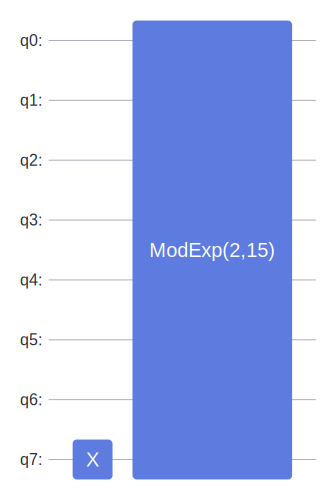

In [4]:
# pylint: disable=W0104
register1 = range(4, 8)
register2 = range(4)
circuit = Circuit(X.on(7))  # 创建线路，使输入态为|1000⟩|0000⟩，即x=8，|8⟩|0⟩
circuit += create_mod_exp_oracle(15, 2, list(register1), list(register2))  # 作用oracle算子
circuit.svg() #打印线路

In [5]:
print(circuit.get_qs('mqvector', ket=True))  # 打印末态

1¦10000001⟩


寄存器1中结果为`1000`，寄存器2中结果为`0001`，先前我们已经算出了$f(8)=2^8 \bmod 15=1$，因此输出结果正确。

接下来我们需要实现周期查找算法。

### 周期查找算法

1. 在寄存器1中我们需要$q>log_2 N$个比特来记录自变量$x \in [0,N-1]$的二进制数，寄存器2中同样需要$q$个比特来记录$f(x)=a^x \bmod N, x \in [0,N-1]$的二进制数。此时寄存器1和寄存器2分别能记录$[0,Q-1]$的整数,其中$Q=2^q>N$。
2. 对寄存器1中的所有比特作用 [Hadamard](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html) 门，此时寄存器1中的比特处于$[0,Q-1]$中所有整数的均匀叠加态

    $$
    |\psi\rangle=\frac{1}{\sqrt{Q}}\sum_{x=0}^{Q-1}|x\rangle
    $$

3. 对寄存器1存储的态$|\psi\rangle$做函数运算$a^{|\psi\rangle} \bmod N$，并将结果存入寄存器2，此步骤由先前构造的U_operator完成。由于直接对叠加态$|\psi\rangle$进行运算，此步骤只需一步完成，体现了量子计算的优势————并行计算。此时线路中存储的态是纠缠态，可以表示为

    $$
    \sum_{x=0}^{Q-1}|x\rangle|f(x)\rangle=\sum_{i=0}^{r-1}(|i\rangle+|i+r\rangle+|i+2r\rangle+...) |f(i)\rangle
    $$

4. 对寄存器1做傅立叶逆变换，此变换使用一个$Q$次单位根$\omega^{2\pi i/Q}$，会将任意给定态$|x\rangle$的振幅平均分布在$Q$个$|y\rangle$态上。而如步骤3中显示的，寄存器1中$|i\rangle$与$|i+r\rangle$等态均与寄存器2中同一个态$|f(i)\rangle$相纠缠，因此会发生量子干涉，最终使得当单位矢量$\omega^{2\pi iry/Q}$越接近1（指向正实数轴）时，测量得到态$|y\rangle$的概率越大。换句话说，我们测得的态$|y\rangle$，有很大概率使得$\frac{ry}{Q}$接近某一整数$c$。更详尽的数学描述可以参考链接：<https://zh.wikipedia.org/wiki/秀爾演算法> 中的“量子部分：周期查找子程序”。
5. 测量寄存器1，得到二进制串。将二进制数转化为十进制数$y$，此时$\frac{y}{Q}\sim\frac{c}{r}$，其中$c$是未知整数。通过连分数分解法计算$\frac{y}{Q}$逼近的不可约分数（分母不大于$N$），取其分母即得到周期$r$。但是，在分母小于$N$的不可约分数中可能存在比$\frac{c}{r}$更逼近$\frac{y}{Q}$的分数，或是$c$与$r$存在公因数，则得到的$r$会是真正函数周期的因数，此时计算失败，重新计算。

举例：还是用$N=15, a=2$的例子，在`构造Oracle`中我们把每一个$f(x)$都算了出来，从中可以直接看出函数周期为4。现在我们可以搭建对应的周期查找线路，并进行100次模拟，看看会得到哪些结果。

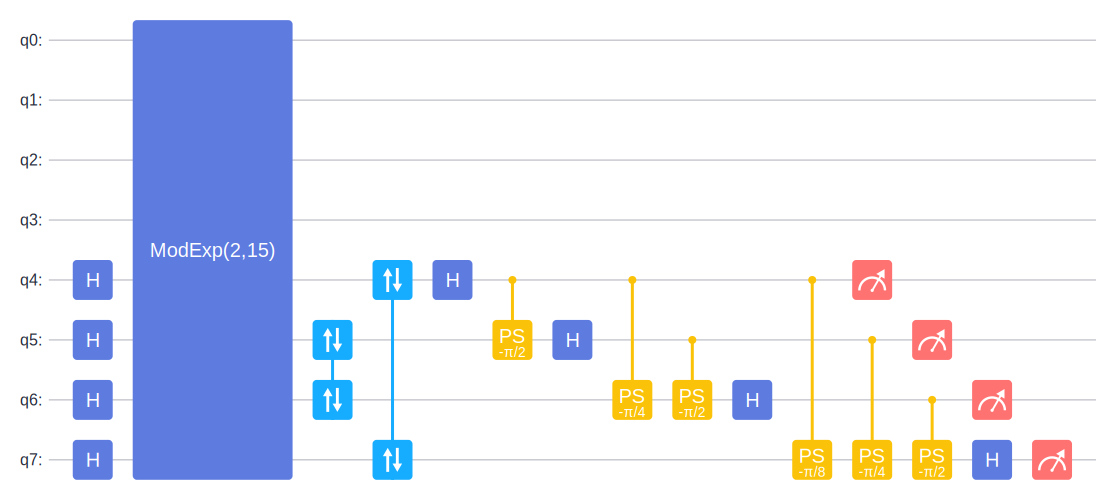

In [6]:
# pylint: disable=W0104
circuit = Circuit()  # 创建量子线路
register1 = range(4, 8)  # 设置后4个比特为寄存器1
register2 = range(4)  # 设置前4个比特为寄存器2

circuit += UN(H, register1)  # 对寄存器1中的所有比特作用H门

# 对寄存器1做模乘运算，并将结果存入寄存器2，该操作由一个大的U门完成
circuit += create_mod_exp_oracle(15, 2, list(register1), list(register2))

circuit += qft(register1[::-1]).hermitian()  # 对寄存器1做傅立叶逆变换，须注意傅立叶变换作用的比特顺序，在这里需要反序
circuit += UN(Measure(), register1)  # 测量寄存器1

circuit.svg()  # 画出线路图

从线路图我们可以很直观地看到，整个周期查找线路由四部分组成：

1. 产生叠加态
2. $rightarrow$函数运算
3. $rightarrow$傅立叶逆变换
4. $rightarrow$测量

接下来运行该线路100次，观察测量结果。

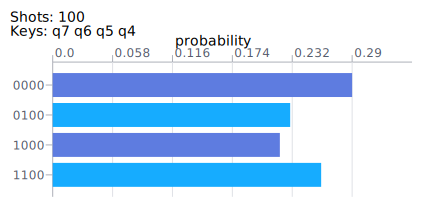

In [7]:
# pylint: disable=W0104
sim = Simulator('mqvector', circuit.n_qubits)  # 创建量子线路模拟器

# 模拟线路100次，打印测量结果，随机种子seed设为100内的随机整数
result = sim.sampling(circuit, shots=100, seed=np.random.randint(100))

result.svg()

从统计结果可以看出，最后寄存器1中只可能测出4个态，分别是$y=[0,4,8,12]$，这是由于$\omega^{2\pi iry/Q}, (Q=16)$当$y$取这四个值时恰好为1，而其他的态由于量子干涉导致概率幅抵消为零。把测量结果代入$\frac{y}{Q}\sim\frac{c}{r}$，可以看出该式确实成立，我们有约50%的概率得到正确的周期$r$，但有约25%概率得到$r$的因数，还有25%概率得到0态，后两种情况需要重新计算。

接下来构造的是通用的周期查找算法。

In [8]:
def period_finder(N, a, q):
    circuit = Circuit()  # 创建量子线路
    register1 = range(q, 2 * q)  # 设置后q个比特为寄存器1
    register2 = range(q)  # 设置前q个比特为寄存器2

    circuit += UN(H, register1)  # 对寄存器1中的所有比特作用H门

    # 对寄存器1做模乘运算，并将结果存入寄存器2，该操作由一个大的U门完成
    circuit += create_mod_exp_oracle(N, a, list(register1), list(register2))

    circuit += qft(register1[::-1]).hermitian()  # 对寄存器1做傅立叶逆变换，须注意傅立叶变换作用的比特顺序，在这里需要反序
    circuit += UN(Measure(), register1)  # 测量寄存器1

    sim = Simulator('mqvector', circuit.n_qubits)  # 创建量子线路模拟器

    # 模拟线路，收集测量结果，随机种子seed设为100内的随机整数
    result = sim.sampling(circuit, seed=np.random.randint(100), shots=1)

    # result.data是一个字典，key是测量结果，value是出现频数，我们只做了一次采样，因此只有一个key，value必定为1
    result = list(result.data.keys())[0]  # 将key取出
    result = int(result, 2)  # 将结果从二进制转化为十进制

    # 通过连分数分解法计算result/2**q逼近的不可约分数，分母不能大于N
    eigenphase = float(result / 2**q)
    f = Fraction.from_float(eigenphase).limit_denominator(N)
    r = f.denominator  # 取f的分母，得到周期r

    # r有可能是周期的因数，因此需要验证，当且仅当r是函数周期本身时返回r，否则返回None
    if pow(a, r, N) == 1:
        return r
    return None

### 经典计算机部分

经典计算机部分负责将因数分解问题转化成寻找函数周期的问题，具体步骤如下：

1. 随机取一个小于$N$的整数$a$，用gcd算法验证$a$与$N$是否互质，若$a$与$N$存在公因数，则直接得到$N$的一个因数，输出结果。

2. 计算需要$q$个比特来存储$N$的二进制数。

3. 用周期查找算法得到函数$f(x)=a^x \bmod N$的周期$r$。

4. 判断$r$是否为偶数，若不是则回到第一步。

5. 计算$a^{r/2}+1$和$a^{r/2}-1$，它们当中必有其一与$N$存在非1公因数。但是，$a^{r/2}+1$有可能可以整除$N$，因此最后输出结果仍有可能是$N$本身。

In [9]:
#pylint: disable=C0121,R1705
def shor(N):
    while True:
        a = np.random.randint(N - 2) + 2  # 获得区间[2,N-1]内的随机整数a
        b = np.gcd(a, N)  # 得到a与N的最大公因数b
        if b != 1:
            return b, int(N / b)  # 如果b不等于1，则b是N的质因数，返回分解结果

        # 获得足够表示N的二进制的比特数q
        q = 0
        while True:
            Q = 2**q
            if Q >= N:
                break
            q += 1

        r = period_finder(N, a, q)  # 使用周期查找算法得到r

        # 判断r是否为偶数,若是则跳出循环，若不是则重新选择随机整数a
        if r != None and r % 2 == 0:
            break

    # 计算a**(r/2)+1和a**(r/2)-1，并验证它们是否与N有公约数，若有则输出结果
    c = np.gcd(a**(int(r / 2)) + 1, N)
    d = np.gcd(a**(int(r / 2)) - 1, N)
    if c != 1 and N % c == 0:
        return c, int(N / c)
    else:
        return d, int(N / d)

需要注意的是，由于我们直接将oracle构造为了一个巨大的酉矩阵门，导致了模拟耗时的大幅增加，因此对于$N>55$的情况，可能需要较长的时间才能得到结果。并且由于前文提到寄存器 1 比特数量的简化，N更大的时候找到正确周期的概率会比较小。

最后让我们试着用写好的Shor算法分解$N=35$。

In [10]:
N = 35
print("Factoring N = p * q =", N)

p, q = shor(N)
print("p =", p)
print("q =", q)

Factoring N = p * q = 35
p = 5
q = 7


从运行结果可以看到，我们成功的分解出35的两个质因数：5和7。

至此，我们成功的使用MindSpore Quantum实现了Shor算法。

In [11]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.10.0
scipy,1.15.2
numpy,1.26.4
System,Info
Python,3.10.16
OS,Darwin arm64
Memory,17.18 GB
CPU Max Thread,10
Date,Fri May 16 19:23:31 2025
